# Answering Business Questions using SQL
***

## Introduction and Schema Diagram

As a reminder below is the schema of the database we will be working with.

![Chinook Database Schema](chinook_schema.png "Chinook Database Schema")

## Creating Helper Functions

In this project, we'll:

* create some helper functions in python to save some time.
* use a context manager to handle the connection to the SQLite database.

Context managers make our life easy by taking care of opening and closing the connection to the database, as well as making sure we don't accidentally make changes to the database if one of our queries has an error.

**In the following code we'll do the following**

1. Import the SQLite, pandas and matplotlib modules, and use the magic command `%matplotlib inline` to make sure any plots render in the notebook.
2. Create a `run_query()` function, that takes a SQL query as an argument and returns a pandas dataframe of that query.
3. Create a `run_command()` function that takes a SQL command as an argument and executes it using the sqlite module.
4. Create a `show_tables()` function that calls the `run_query()` function to return a list of all tables and views in the database.
5. Run the `show_tables()` function.

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

db = 'chinook.db'

def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)

def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)

def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


Now we're going to answer to some questions.

## Selecting Albums to Purchase

The Chinook record store has just signed a deal with a new record label, and we've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

|Artist Name|Genre|
|---|---|
|Regal|Hip-Hop|
|Red Tone|Punk|
|Meteor and the Girls|Pop|
|Slim Jim Bites|Blues|

*The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sells the most in the USA.*

We'll need to write a query to find out which genres sell the most tracks in the USA, and then create a visualization of that data using pandas.

**The following code does the following**

1. Write a query that returns each genre, with the number of tracks sold in the USA:
  * in absolute numbers
  * in percentages.
2. A plot which shows this data.

In summary we're generating a frequency distribution for the genres and selecting the top 10.

In [2]:
albums_to_purchase = '''
WITH tracks_sold_usa AS (
  SELECT il.* 
    FROM invoice_line il
  INNER JOIN invoice i ON il.invoice_id = i.invoice_id
  INNER JOIN customer c ON i.customer_id = c.customer_id
  WHERE c.country = 'USA'
)    
SELECT g.name genre,
	  COUNT(tsu.invoice_line_id) tracks_sold,
	  CAST(COUNT(tsu.invoice_line_id) AS FLOAT) / (SELECT COUNT(*) FROM tracks_sold_usa) percentage_sold
  FROM tracks_sold_usa tsu
INNER join track t ON tsu.track_id = t.track_id
INNER JOIN genre g ON t.genre_id = g.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;
'''
 
run_query(albums_to_purchase)

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Pop,22,0.020932
7,Latin,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


Let's visualise the results

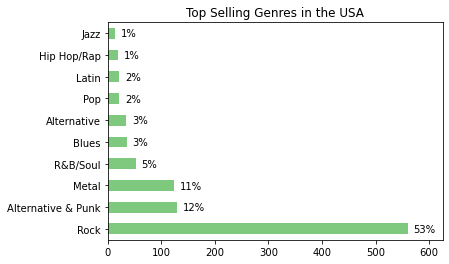

In [3]:
genre_sales_usa = run_query(albums_to_purchase)
genre_sales_usa.set_index("genre", inplace=True, drop=True)

genre_sales_usa["tracks_sold"].plot.barh(
    title="Top Selling Genres in the USA",
    xlim=(0, 625),
    colormap=plt.cm.Accent
)

plt.ylabel('')

for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "tracks_sold"]
    label = (genre_sales_usa.loc[label, "percentage_sold"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()

Based on the sales of tracks across different genres in the USA, we should purchase the new albums by the following artists:

* Red Tone (Punk)
* Slim Jim Bites (Blues)
* Meteor and the Girls (Pop)

It's worth keeping in mind that combined, these three genres only make up about 17% of total sales, so we should be on the lookout for artists and albums from the 'Rock' genre, which accounts for 53% of sales.

## Analyzing Employee Sales Performance

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. We have been tasked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

**The following code does the following**

1. Finds the total dollar amount of sales assigned to each sales support agent within the company. We can add any extra attributes for that employee that we find are relevant to the analysis.
2. Then we create a plot of the results of our query.

In [4]:
employee_sales_performance = '''
WITH customer_agents AS
    (
     SELECT
         i.customer_id,
         c.support_rep_id,
         SUM(i.total) total
     FROM invoice i
     INNER JOIN customer c ON i.customer_id = c.customer_id
     GROUP BY 2
    )

SELECT
    e.first_name || " " || e.last_name employee,
    e.hire_date,
    SUM(ca.total) total_sales
FROM customer_agents ca
INNER JOIN employee e ON e.employee_id = ca.support_rep_id
GROUP BY 1;
'''

run_query(employee_sales_performance)

,employee,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


The following is a plot of our query

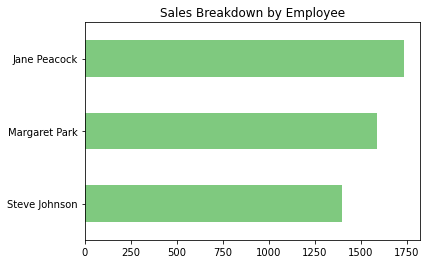

In [5]:
employee_sales = run_query(employee_sales_performance)

employee_sales.set_index("employee", drop=True, inplace=True)
employee_sales.sort_values("total_sales", inplace=True)
employee_sales.plot.barh(
    legend=False,
    title='Sales Breakdown by Employee',
    colormap=plt.cm.Accent
)
plt.ylabel('')
plt.show()

While there is a 20% difference in sales between Jane (the top employee) and Steve (the bottom employee), the difference roughly corresponds with the differences in their hiring dates.

## Analyzing Sales by Country

Our next task is to analyze the sales data for customers from each different country. You have been given guidance to use the country value from the `customers` table, and ignore the country from the billing address in the `invoice` table.

In particular, we have been directed to calculate data, for each country, on the:

* total number of customers
* total value of sales
* average value of sales per customer
* average order value

**The code below does the following**

1. Writes a query that collates data on purchases from different countries. For each country, include:
  * total number of customers
  * total value of sales
  * average value of sales per customer
  * average order value
2. Where a country has only one customer, collect them into an "Other" group.
3. The results should be sorted by the total sales from highest to lowest, with the "Other" group at the very bottom.

*average value of sales per customer* is total sales of customers in a country / number of customers in the country.

*average order value* is total sales in a country / total orders for that country

In [6]:
sales_by_country = '''
WITH country_or_other AS (
  SELECT 
    CASE WHEN (
      SELECT COUNT(*)
        FROM customer
       WHERE country = c.country
    ) = 1 THEN 'Other' ELSE c.country 
    END AS country,
    c.customer_id,
    il.*
    FROM invoice_line il
   INNER JOIN invoice i ON il.invoice_id = i.invoice_id
   INNER JOIN customer c ON i.customer_id = c.customer_id
)
SELECT 
  country,
  customers,
  total_sales,
  average_order,
  customer_lifetime_value
FROM  
(
SELECT
  country,
  COUNT(DISTINCT customer_id) customers,
  SUM(unit_price) total_sales,
  SUM(unit_price) / COUNT(DISTINCT customer_id) customer_lifetime_value,
  SUM(unit_price) / COUNT(DISTINCT invoice_id) average_order,
  CASE WHEN country = 'Other' THEN 1 ELSE 0 END as sort
FROM country_or_other
GROUP by country
ORDER by sort ASC,
         total_sales DESC
);
'''
run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


## Visualizing Sales by Country

Now that we have our data, let's do a series of visualisations which communicate our findings, and then make recommendations on which countries may have potential for growth, so the Chinook marketing team can create some new advertising campaigns.

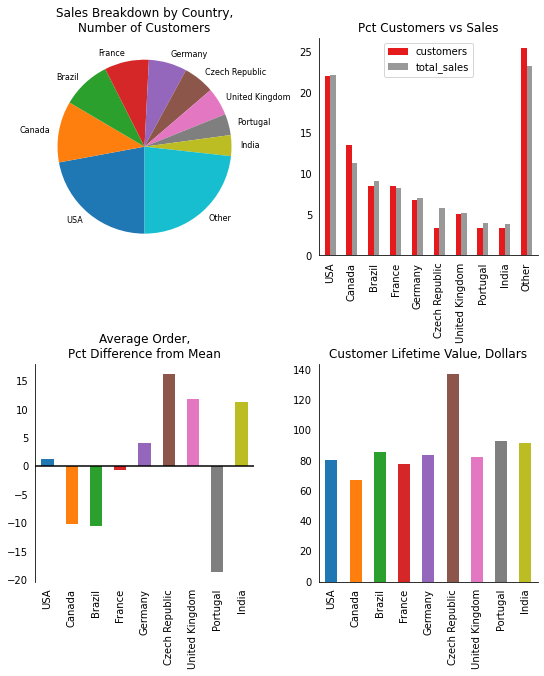

In [7]:
# NOTE 1
# ------
# ~/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning:
# Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
#   warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "

# Please change False to "off" if you are getting any error or unexpected output.

# NOTE 2
# ------
# Accent colormap only contains 8 colors, therefore colors will be repeated if we use it for our data.
# Therefore, I chose to use tab10 colormap.


country_metrics = run_query(sales_by_country)
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.tab10(i) for i in np.linspace(0, 1, country_metrics.shape[0])] # Refer to NOTE 2

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.tab10, # Refer to NOTE 2
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# top right
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100 # This is computing the relative frequency distribution
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top=False, right=False, left=False, bottom=False) # Refer to NOTE 1
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# bottom left
avg_order = country_metrics["average_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top=False, right=False, left=False, bottom=False) # Refer to NOTE 1
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics["customer_lifetime_value"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top=False, right=False, left=False, bottom=False) # Refer to NOTE 1
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

I would recommend to invest in Czech Republic. The reason is that, even though the customers are low in Czech Republic, the Sales is high. Czech Republic is at top when it comes to Customer Lifetime Value, which is the average value of sales per customer. So if the company can increase the customer base there then it can easily attain more profits in Czech Republic than any other country.

## Albums vs Individual Tracks

The Chinook store is setup in a way that allows customer to make purchases in one of the two ways:

* purchase a whole album
* purchase a collection of one or more individual tracks.

The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

It is very common when you are performing an analysis to have 'edge cases' which prevent you from getting a 100% accurate answer to your question. In this instance, we have two edge cases to consider:

* Albums that have only one or two tracks are likely to be purchased by customers as part of a collection of individual tracks.
* Customers may decide to manually select every track from an album, and then add a few individual tracks from other albums to their purchase.

In the first case, since our analysis is concerned with maximizing revenue we can safely ignore albums consisting of only a few tracks. The company has previously done analysis to confirm that the second case does not happen often, so we can ignore this case also.

In order to answer the question, we're going to have to identify whether each invoice has all the tracks from an album. We can do this by getting the list of tracks from an invoice and comparing it to the list of tracks from an album. We can find the album to compare the purchase to by looking up the album that one of the purchased tracks belongs to. It doesn't matter which track we pick, since if it's an album purchase, that album will be the same for all tracks.

**The query below does the following**

1. Categorizes each invoice as either an album purchase or not, and calculates the following summary statistics:
  * Number of invoices
  * Percentage of invoices

In [8]:
album_vs_tracks = '''
WITH invoice_album as (
  SELECT il.invoice_id,                                     
         t.album_id
    FROM invoice_line il
    LEFT JOIN track t 
      ON t.track_id = il.track_id
   GROUP by 1),
   
   album_vs_tracks as (
     SELECT 
      ia.*,
      CASE WHEN (
        SELECT t.track_id
        FROM track t
       WHERE t.album_id = ia.album_id
      EXCEPT   
      SELECT il.track_id
        FROM invoice_line il
       WHERE il.invoice_id = ia.invoice_id
      ) ISNULL
      AND (
      SELECT il.track_id
        FROM invoice_line il
       WHERE il.invoice_id = ia.invoice_id
      EXCEPT
      SELECT t.track_id
        FROM track t
       WHERE t.album_id = ia.album_id
      ) ISNULL 
      THEN 'yes' 
      ELSE 'no'
      END AS 'album_purchase'
    FROM invoice_album ia
    )
SELECT
  album_purchase,
  COUNT(invoice_id) number_invoices,
  CAST(COUNT(invoice_id) as FLOAT) / (
                                     SELECT COUNT(*) FROM invoice
                                     ) percent
FROM album_vs_tracks
GROUP by album_purchase;
'''
run_query(album_vs_tracks)

,album_purchase,number_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


We see that customers tend to buy more individual tracks than albums, so the new strategy (purchasing only the most popular tracks from each album from record companies instead of purchasing the whole albums) sound impressive. However, from our calculations we see that album purchases account for 18.6% of purchases. Based on this data, I would recommend against purchasing only select tracks from albums from record companies, since there is potential to lose one fifth of revenue.

From the following section we'll answering miscellaneous question about the chinook database.

## The Most Popular Artists
We're going to find out which artists are used in the most playlists. This information can give us valuable insights on further purchasing strategies of the Chinook store.

**The query below does the following**
* Selects the artists name and counts the total number of playlists they're featured.

In [9]:
pop_artist = '''
SELECT ar.name,
       COUNT(DISTINCT pt.playlist_id) num_playlist
  FROM artist ar
 INNER join album al 
    on ar.artist_id = al.artist_id
 
 INNER JOIN track t
    on al.album_id = t.album_id
    
 INNER JOIN playlist_track pt
    on t.track_id = pt.track_id
 GROUP by 1
 ORDER by 2 DESC
 LIMIT 5;
'''
run_query(pop_artist)

,name,num_playlist
0,Eugene Ormandy,7
1,The King's Singers,6
2,English Concert & Trevor Pinnock,6
3,Berliner Philharmoniker & Herbert Von Karajan,6
4,Academy of St. Martin in the Fields & Sir Nevi...,6


Our query returned the Top 5 artists, with [Eugene Ormandy](https://en.wikipedia.org/wiki/Eugene_Ormandy) at the first place (present in 7 playlists), and followed by 4 other artists (present in 6 playlists). Let's have a look at which genres the tracks of these artists are related.

In [10]:
genre_pop_artist = '''
 SELECT DISTINCT g.name genre
  FROM genre g
       INNER JOIN track t 
       ON t.genre_id = g.genre_id   
    
       INNER JOIN album al 
       ON al.album_id = t.album_id
    
       INNER JOIN artist ar 
       ON ar.artist_id = al.artist_id    
 WHERE ar.name = "Eugene Ormandy" 
    OR ar.name = "The King's Singers"
    OR ar.name = "English Concert & Trevor Pinnock"
    OR ar.name = "Berliner Philharmoniker & Herbert Von Karajan" 
    OR ar.name = "Academy of St. Martin in the Fields & Sir Neville Marriner";
'''
run_query(genre_pop_artist)

,genre
0,Classical


From our previous queries (calculating the top 10 albums of each genre sold in the USA), we remember that Classical genre, with all due respect, doesn't even feature in the top 10 and thus is far away from being the most sold one. Hence, in spite of these artists being present in the most playlists, a strategy for the Chinook store to buy more tracks of theirs _cannot be considered as potentially profitable_ and should be disregarded.

## Purchased vs Not Purchased Tracks
Let's now find out how many unique tracks were sold.

**The query below does the following**
Calculates the proportions of all tracks in the database to those sold.

In [11]:
all_vs_sold = '''
SELECT COUNT(DISTINCT t.track_id) all_tracks,
       COUNT(DISTINCT il.track_id) sold_tracks,
       COUNT(DISTINCT il.track_id)*1.0 / COUNT(DISTINCT t.track_id) pct_sold
  FROM track t
  LEFT JOIN invoice_line il
    ON il.track_id = t.track_id
'''
run_query(all_vs_sold)

,all_tracks,sold_tracks,pct_sold
0,3503,1806,0.515558


Almost half of all the unique tracks available in the Chinook store were never bought, probably being of unpopular genre or unpopular artists. Possible solutions here may include a new _advertising campaign_, _sales promotion_, additional _training and motivation_ of the sales support agents.

## Popularity of Protected vs Non-Protected Media Types

If a track has a protected media type, it means that it has some associated rules for using its content. It can be encrypted using some form of digital rights management encryption. To play such a file, playback must occur inside the protected media path. In addition, the user might have to acquire rights to the content.

Let's start by looking at the unique values of media types and whether there are any protected types among them.

In [12]:
media_type = '''
SELECT name AS media_type
  FROM media_type;
'''
run_query(media_type)

,media_type
0,MPEG audio file
1,Protected AAC audio file
2,Protected MPEG-4 video file
3,Purchased AAC audio file
4,AAC audio file


Two of the five media types are protected. 

Now, we're going to calculate the summary statistics for all protected vs. non-protected media types.

In [13]:
p_vs_np = '''
with non_protected as (
SELECT COUNT(mt.name) to_be_renamed, 
       COUNT(DISTINCT t.track_id) unique_tracks, 
       COUNT(DISTINCT il.track_id) sold_unique,
       COUNT(il.track_id) sold
  FROM media_type mt
 INNER JOIN track t 
    ON mt.media_type_id = t.media_type_id

  LEFT JOIN invoice_line il 
    ON il.track_id = t.track_id                        
 WHERE mt.name != "Protected AAC audio file" 
   AND mt.name != "Protected MPEG-4 video file"
  ),
protected as (   
SELECT COUNT(mt.name) to_be_renamed, 
       COUNT(DISTINCT t.track_id) unique_tracks, 
       COUNT(DISTINCT il.track_id) sold_unique,
       COUNT(il.track_id) sold
  FROM media_type mt
 INNER JOIN track t 
    ON mt.media_type_id = t.media_type_id

  LEFT JOIN invoice_line il 
    ON il.track_id = t.track_id                        
 WHERE mt.name = "Protected AAC audio file" 
   or mt.name = "Protected MPEG-4 video file"
  ),
combined as (
  SELECT
    CASE WHEN to_be_renamed != 0 THEN "Non-protected" 
         END AS media_type,
         unique_tracks,     
         sold_unique,
         ROUND(sold_unique * 100.0 / unique_tracks, 0) pct_sold_unique,
         sold  
    FROM non_protected
  UNION
  SELECT
    CASE WHEN to_be_renamed != 0 THEN "Protected" 
         END AS media_type,
         unique_tracks,     
         sold_unique,
         ROUND(sold_unique * 100.0 / unique_tracks, 0) pct_sold_unique,
         sold  
    FROM protected)
SELECT media_type,
       unique_tracks,
       ROUND(unique_tracks * 100.0 / (SELECT SUM(unique_tracks) 
                               FROM combined), 0) pct_unique,    
       sold_unique,
       pct_sold_unique,
       sold,
       ROUND(sold * 100.0 / (SELECT SUM(sold) 
                               FROM combined), 0) pct_sold
FROM combined;
'''
run_query(p_vs_np)

,media_type,unique_tracks,pct_unique,sold_unique,pct_sold_unique,sold,pct_sold
0,Non-protected,3052,87.0,1652,54.0,4315,91.0
1,Protected,451,13.0,154,34.0,442,9.0


From the queried table, we can make the following observations:
- Only 13\% of all the unique tracks available in the Chinook store are of protected media types.
- From all the unique tracks of protected media types, only 34\% were sold, while from those of non-protected ones - 54\%.
- Among all the tracks that were sold, those of protected media types amounts only to 9%.

In a nutshell, the **tracks of protected media types are much less popular** than those of non-protected, both in terms of the store assortment and, especially, in terms of sales. It can be easily explained by a cumbersome way of their using, which is not really justified when it comes to buying media products for entertainment. Hence, as a future strategy, it is not recommended to the store to purchase such tracks from record companies.

## Conclusion
In this project, we have analyzed a modified version of the Chinook database for finding the answers to our business questions. Below are the main results of this work (emphasized are the factors and suggestions for maximizing overall revenue):
- From the 4 albums in consideration, the following 3 ones should be  selected for purchasing and advertising in the USA, based on the genre popularity rating in  this country: **Red Tone** (Punk), **Slim Jim Bites** (Blues), **Meteor and the Girls** (Pop). We concluded by recommending that the marketing team be on the lookout for artists and albums from the 'Rock' genre, which accounts for 53% of sales.
- Of the 3 sales support agents, **Jane Peacock** demonstrates the most effective sales performance, while Steve Johnson - the least. The main contributing factor is the hiring date.
- Of all the countries, the **USA** represents the majority of the market, in terms of both the total sales and the number of customers. However, we recommend that investments be made at the Czech Republic as the sales are high even though the customer base is small. So it's of utmost importance to increase the customer base there.
- We saw that customers tend to buy **individual tracks** much more often than the whole albums. However, it's recommended to the Chinook store against purchasing only the most popular tracks from each album from record companies. As there is potential to lose one fifth of revenue.
- The tracks of the artists present in the most playlists are all of Classical genre, which does not feature popular amongst the top 10 purchased albums in the USA. Purchasing more tracks from that genre cannot be considered as a potentially profitable strategy for the Chinook store. 
- Almost half of all the unique tracks of the Chinook store were never bought. Possible solutions here may include a new **advertising campaign**, **sales promotion**, additional **training and motivation** of sales support agents.
- The tracks of protected media types are much less popular than those of **non-protected**, both in terms of the store assortment and, especially, in terms of sales. Hence the store should decrease purchasing a volume of such tracks.